In [1]:
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import numpy as np
from encoder import *
import torch
import math
import glob
from scipy.stats import pearsonr

c:\anaconda3\envs\master\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def correlate(model1, model2, data_input_1, data_input_2, flag=False):
    # Check if encoder output channels are compatible
    if model1.encoder._out_channels[1:] != model2.encoder._out_channels[1:] or flag:
        print(torch.softmax(model2(data_input_2), dim=1)[:, 1].detach().cpu().shape)
        return None, None, pearsonr(
            torch.softmax(model1(data_input_1), dim=1)[:, 1].detach().cpu().flatten(),
            torch.softmax(model2(data_input_2), dim=1)[:, 1].detach().cpu().flatten()
        )

    # Forward pass through both encoders
    encoder_1 = model1.encoder(data_input_1)
    encoder_2 = model2.encoder(data_input_2)

    # Lists to store the intermediate outputs of the decoder blocks for both models
    decoder_block_outputs1 = []
    decoder_block_outputs2 = []

    # Hook function to capture outputs from each decoder block of model1
    def hook_fn1(module, input, output):
        decoder_block_outputs1.append(output)

    # Hook function to capture outputs from each decoder block of model2
    def hook_fn2(module, input, output):
        decoder_block_outputs2.append(output)

    # Register hooks for decoder blocks in both models
    for block in model1.decoder.blocks:
        block.register_forward_hook(hook_fn1)

    for block in model2.decoder.blocks:
        block.register_forward_hook(hook_fn2)

    # Forward pass through the decoders (the hooks will capture the intermediate outputs)
    decoder_1 = model1.decoder(*encoder_1)
    decoder_2 = model2.decoder(*encoder_2)

    # Get predictions
    preds1 = torch.softmax(model1(data_input_1), dim=1)[:, 1]
    preds2 = torch.softmax(model2(data_input_2), dim=1)[:, 1]

    # Encoder correlation
    corr_encoder = {}
    for i in range(1, len(encoder_1)):
        corr_encoder[i] = pearsonr(
            encoder_1[i].detach().cpu().numpy().flatten(),
            encoder_2[i].detach().cpu().numpy().flatten()
        )

    # Decoder correlation (using the outputs captured by the hooks)
    corr_decoder = {}
    for i in range(len(decoder_block_outputs1)):
        corr_decoder[i] = pearsonr(
            decoder_block_outputs1[i].detach().cpu().numpy().flatten(),
            decoder_block_outputs2[i].detach().cpu().numpy().flatten()
        )

    # Correlation of final predictions
    corr_preds = pearsonr(preds1.detach().cpu().flatten(), preds2.detach().cpu().flatten())

    return corr_encoder, corr_decoder, corr_preds


In [3]:
model1 = smp.Unet(
            encoder_name=f"single_encoder_6",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model2 = smp.Unet(
            encoder_name=f"single_encoder_12",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model3 = smp.Unet(
            encoder_name="dual_encoder_dft",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model4 = smp.Unet(
            encoder_name="dual_resnet_encoder",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model5 = smp.Unet(
            encoder_name="resnet50",
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model6 = smp.Unet(
            encoder_name=f"single_encoder_24",
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

model7 = smp.Unet(
            encoder_name="dual_encoder_wav",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )

# Loading data from precomputed dataset
path = "C:/Users/The Son/Desktop/Uni/Berlin/Masterarbeit/Data/model_data/test"
# Data/ms-dataset-chips\\95eff095-c3e9-4c12-bfde-1708b7e19bae\\s2\\S2A_MSIL1C_20170528T050611_N0205_R076_T44NNP_20170528T050606_00960-03063\\B12.tif'
data = np.load(f"{path}/1.npz", allow_pickle=True)
data = data["arr_0"][0]
X = data["image"]
X = torch.tensor(np.expand_dims(X, axis=0))
amps = data["amplitude"]
phases = data["phase"]
wavelets = torch.tensor(np.expand_dims(data["wavelet"], axis=0)).cuda(non_blocking=True).float()
X = X.cuda(non_blocking=True).float()
ap = torch.tensor(np.expand_dims(np.concatenate([amps, phases], axis=0), axis=0)).cuda(non_blocking=True).float()

X_ap = np.concatenate([X.cpu().numpy(), ap.cpu().numpy()], axis=1)  # Concatenate on CPU first
X_ap = torch.tensor(X_ap).cuda(non_blocking=True).float()

In [4]:
# Load model 1
model_weights_path_1 = glob.glob(f"trained_models/baseline/best_iou*")[0]
model1 = model1.cuda()
model1.eval()
cp = torch.load(model_weights_path_1)
model1.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_1} at epoch {cp['epoch_num']}")

# Load model 2
model_weights_path_2 = glob.glob(f"trained_models/dft/best_iou*")[0]
model2 = model2.cuda()
model2.eval()
cp = torch.load(model_weights_path_2)
model2.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_2} at epoch {cp['epoch_num']}")

# Load model 3
model_weights_path_3 = glob.glob(f"trained_models/baseline_dft/best_iou*")[0]
model3 = model3.cuda()
model3.eval()
cp = torch.load(model_weights_path_3)
model3.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_3} at epoch {cp['epoch_num']}")

# Load model 4
model_weights_path_4 = glob.glob(f"trained_models/baseline_deep/best_iou*")[0]
model4 = model4.cuda()
model4.eval()
cp = torch.load(model_weights_path_4)
model4.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_4} at epoch {cp['epoch_num']}")

# Load model 5
model_weights_path_5 = glob.glob(f"trained_models/deep/best_iou*")[0]
model5 = model5.cuda()
model5.eval()
cp = torch.load(model_weights_path_5)
model5.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_5} at epoch {cp['epoch_num']}")

# Load model 6
model_weights_path_6 = glob.glob(f"trained_models/wavelet/best_iou*")[0]
model6 = model6.cuda()
model6.eval()
cp = torch.load(model_weights_path_6)
model6.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_6} at epoch {cp['epoch_num']}")

# Load model 7
model_weights_path_7 = glob.glob(f"trained_models/baseline_wavelet/best_iou*")[0]
model7 = model7.cuda()
model7.encoder.wav = wavelets
model7.eval()
cp = torch.load(model_weights_path_7)
model7.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path_7} at epoch {cp['epoch_num']}")

Loaded trained_models/baseline\best_iou_35_0.7432.pt at epoch 35
Loaded trained_models/dft\best_iou_3_0.1556.pt at epoch 3
Loaded trained_models/baseline_dft\best_iou_21_0.7525.pt at epoch 21
Loaded trained_models/baseline_deep\best_iou_16_0.7599.pt at epoch 16
Loaded trained_models/deep\best_iou_23_0.5502.pt at epoch 23
Loaded trained_models/wavelet\best_iou_16_0.2671.pt at epoch 16
Loaded trained_models/baseline_wavelet\best_iou_9_0.3761.pt at epoch 9


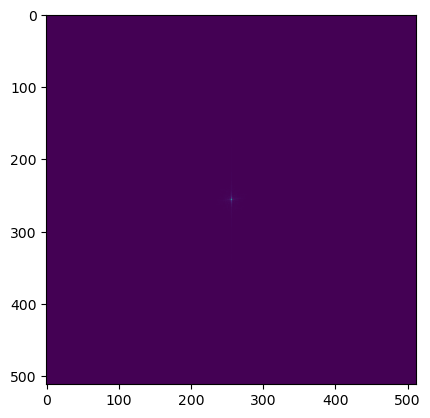

In [25]:
plt.imshow(X_ap[:, -12:, :, :].cpu().squeeze(0)[4, :, :])

In [9]:
params = [ap, X_ap, X, X[:, :3, :, :], wavelets, X]
i = 2
for model, params in zip([model2, model3, model4, model5, model6, model7], params):
    corr_enc, corr_dec, corr_pred = correlate(model1, model, X, params, True)
    print(f"model{i}: {corr_enc}, {corr_dec}, {corr_pred}")
    i += 1
    torch.cuda.empty_cache()

torch.Size([1, 512, 512])
model2: None, None, PearsonRResult(statistic=0.37966579213565665, pvalue=0.0)
torch.Size([1, 512, 512])
model3: None, None, PearsonRResult(statistic=0.32944795314766717, pvalue=0.0)
torch.Size([1, 512, 512])
model4: None, None, PearsonRResult(statistic=0.6353588703710444, pvalue=0.0)
torch.Size([1, 512, 512])
model5: None, None, PearsonRResult(statistic=0.7818044252309995, pvalue=0.0)
torch.Size([1, 512, 512])
model6: None, None, PearsonRResult(statistic=-0.06262492236485173, pvalue=5.1255461456061845e-226)
torch.Size([1, 512, 512])
model7: None, None, PearsonRResult(statistic=0.402275447354167, pvalue=0.0)
